# Tutorial: Single chromosome optimization using OpenMiChroM


## This tutorial performs optimization in the MiChroM Parameters (Second-order optimization -> Hessian inversion)

*The first step is to import the OpenMiChroM modules.*

To install OpenMM and OpenMiChroM, follow the [instalation guide](https://open-michrom.readthedocs.io/en/latest/#).

The inputs and apps used in this tutorial can be downloaded [here](https://github.com/junioreif/OpenMiChroM/tree/main/Tutorials/MiChroM_Optimization).

<font color='red'>Types optimization is available in the OpenMichroM version 1.0.7.</font> 

In [1]:
# OpenMiChroM simulation module
from OpenMiChroM.ChromDynamics import MiChroM
# Optimization of MiChroM parameters module
from OpenMiChroM.Optimization import CustomMiChroMTraining
# Analysis tools module
from OpenMiChroM.CndbTools import cndbTools

# Extra modules to load and plot .dense file 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import h5py

*The second step is to have a look on the experimental Hi-C*

A Hi-C file is required for the analysis and training of the MiChroM Potentials (Types and Ideal Chromosome). The file format chosen here is a matrix .txt file (we call it the dense file).

For this tutorial, we will use chromosome 10 from GM12878 in 100 kb resolution. To extract it from the .hic file, we can use juicer_tools with the folowing command. Please note that the juicer_tools java file is located at the `apps` folder located at the `$HOME` directory.

In [2]:
%%bash
java -jar ~/apps/juicer_tools_1.22.01.jar dump observed Balanced -d https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 10 BP 100000 input/chr10_100k.dense

WARN [2023-04-12T16:57:06,474]  [Globals.java:138] [main]  Development mode is enabled
INFO [2023-04-12T16:57:07,262]  [DirectoryManager.java:179] [main]  IGV Directory: /Users/ro21/igv
INFO [2023-04-12T16:57:07,527]  [HttpUtils.java:937] [main]  Range-byte request succeeded


This command downloads the .hic from the web and extracts the chromosome 10 in .dense format to the folder "input".

You can get more information about it at the [JuicerTools](https://github.com/aidenlab/juicer) documentation.

Visualize the .dense file for inspection

number of beads:  1356


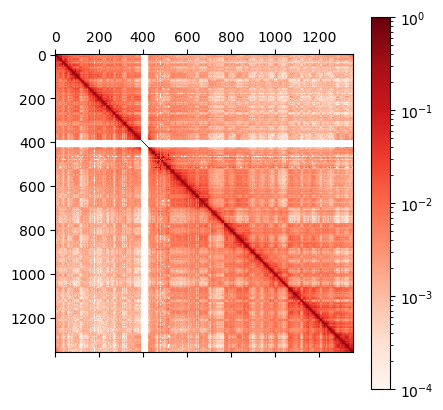

In [5]:
filename = 'input/chr10_100k.dense'
hic_file = np.loadtxt(filename)

r=np.triu(hic_file, k=1) 
r[np.isnan(r)]= 0.0
r = normalize(r, axis=1, norm='max') 
rd = np.transpose(r) 
r=r+rd + np.diag(np.ones(len(r)))
print("number of beads: ", len(r))
plt.matshow(r,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()),cmap="Reds")  
plt.colorbar()

This Hi-C map has a resolution of 100 kb per bead, so the chromosome 10 model has a polymer chain with a total of 1356 beads.

The next step is to extract the sequence file containing the A/B compartments along the sequence by using the eigenvector decomposition. <br>

Using the juicertools, you can extract the eigenvector file. The eigenvector has values both negatives and positives and here we will arbitrary set positives as B and negatives as A. <br>

For more details about how it works, please take a look on this paper: https://pubs.acs.org/doi/full/10.1021/acs.jpcb.1c04174

In [7]:
%%bash
java -jar ~/apps/juicer_tools_1.22.01.jar eigenvector -p Balanced https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 BP 100000 input/chr10_100k.eigen

WARN [2023-04-12T17:06:51,281]  [Globals.java:138] [main]  Development mode is enabled
INFO [2023-04-12T17:06:51,801]  [DirectoryManager.java:179] [main]  IGV Directory: /Users/ro21/igv
INFO [2023-04-12T17:06:52,013]  [HttpUtils.java:937] [main]  Range-byte request succeeded


And visualize the .eigen file.

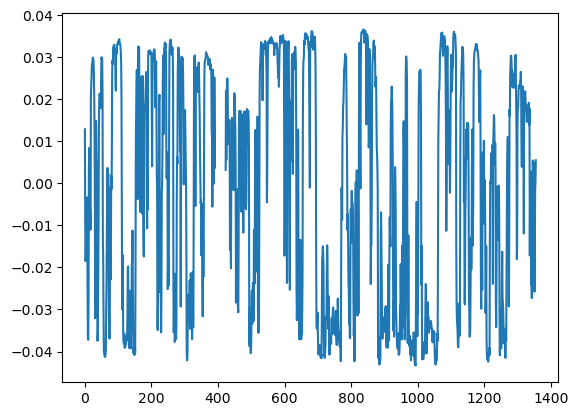

In [8]:
eigen = np.loadtxt("input/chr10_100k.eigen")
plt.plot(eigen)

From the .eigen, file we can create the A/B sequence file.

In [13]:
%%bash
awk '{if ($1 < 0) print "A"; else print "B"}' input/chr10_100k.eigen | cat -n > input/seq_chr10_100k.txt
echo "Number of beads: "
awk '{print $2}' input/seq_chr10_100k.txt | sort | uniq -c

Number of beads: 
 618 A
 738 B


## Types Interaction Opmization

In addition to the homopolimer term, MiChroM energy function has two main terms: the type-to-type and Ideal Chromosome interactions. 

![](https://pubs.acs.org/cms/10.1021/acs.jpcb.1c04174/asset/images/medium/jp1c04174_m010.gif)

In this section, the types interaction terms will be minimized.

The pipeline to perform the Types Potential Optimization is the following:

1. Run a long simulation using the homopolymer potential + customTypes potential of the `OpenMiChroM` module. 
    The first iteration can start with all parameters equal to zero or set to an initial guess.

2. Get the frames from this simualtion to perform the inversion for Types.

3. In the end of the inversion, new values to types interactions will be produced.

4. Calcule the error/tolerance between the simulated and experimental parameters. If it is above the treshold, re-do steps 1-3 until reaching the treshold (usually 10% or 15% is enougth).

The Types file is a `.txt` with a matrix labeled with the values for each interaction. In this tutorial, we are training A and B types. <br> 

Lets create the initial file with this format:
<pre><code>
A,B
0,0
0,0
</pre></code>
For this matrix, we have AA AB BA BB interactions.

Save it as `lambda_0.txt`

In [14]:
%%bash
echo "A,B
0,0
0,0" > input/lambda_0

cat input/lambda_0

A,B
0,0
0,0


With all the required inputs, lets perform a simulation for iteration 0.

In MiChroM initiation there are some variables to setup:

**time_step=0.01** (the time step using for integration, default is 0.01)<br>
**temperature=1** (Set the temperature of your simulation)<br>
**name='opt_chr10_100K'** (the simulation name)<br>

In [15]:
simulation = MiChroM(name='opt_chr10_100K',temperature=1.0, time_step=0.01)

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.6 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

Now you need to setup the platform that you will use, the options are:

**platform="OpenCL"** (it can also be CUDA or CPU depending of your system)<br>
**GPU="0" (optional)** (if you have more than one GPU device, you can set the GPUs that you want ["0", "1",...,"n"])<br>

In [16]:
simulation.setup(platform="OpenCL")

Set the folder name where the output will be saved.

In [17]:
simulation.saveFolder('iteration_0')

The next step is to setup your chromosome sequence and initial configuration.

In [18]:
mychro = simulation.createSpringSpiral(ChromSeq="input/seq_chr10_100k.txt")

Load the initial structure in the `simulation` object.

In [19]:
simulation.loadStructure(mychro, center=True)

Now it is time to include the force field in the `simulation` object

Lets separate forces in two sets:

**Homopolymer Potentials**  

In [9]:
simulation.addFENEBonds(kfb=30.0)
simulation.addAngles(ka=2.0)
simulation.addRepulsiveSoftCore(Ecut=4.0)

**Chromosome Potentials**

In this tutorial, it is used the CustomTypes potential. <br>
Here we need to pass a file that contains a matrix of interactions for each other different type of chromosome.
To check that, you can look on the [OpenMiChroM](https://open-michrom.readthedocs.io/en/latest/OpenMiChroM.html#OpenMiChroM.ChromDynamics.MiChroM.addCustomTypes) documentation. <br>

In [20]:
simulation.addCustomTypes(mu=3.22, rc = 1.78, TypesTable='input/lambda_0')

Note: these valeus for $\mu$ and $r_c$ were calculated for human GM12878 cells and can be changed for other species.

The last potential to be added is the spherical restraint in order to collapse the initial structure.

In [21]:
simulation.addFlatBottomHarmonic(kr=5*10**-3, n_rad=8.0)

Now we will run a short simulation in order to get a collapsed structure.

There are two variables that control the chromosomes simulation steps:

**block:** The number of steps performed in each cycle (n_Blocks)<br>
**n_blocks:** The number of blocks that will be perfomed. <br>

In this example, to perfom the collapsing we will run $5\times10^2 \times  10^3 = 5\times10^5$ steps

In [22]:
block    = 500
n_blocks = 1000

We can save the radius of gyration of each block to observe the convergence into the collapsed state (the time required here depends on the size of your chromosome).

In [23]:
rg = []

In [25]:
for _ in range(n_blocks):
    simulation.runSimBlock(block, increment=False)
    rg.append(simulation.chromRG())

#save a collapsed structure in pdb format for inspection
simulation.saveStructure(mode = 'pdb')

bl=0 pos[1]=[100.2 -2.8 -2.5] dr=2.65 t=10.0ps kin=1.70 pot=10.48 Rg=72.485 SPS=1416 
bl=0 pos[1]=[99.7 -0.7 -4.0] dr=2.73 t=15.0ps kin=1.76 pot=10.15 Rg=71.453 SPS=1663 
bl=0 pos[1]=[99.3 1.2 -3.6] dr=2.83 t=20.0ps kin=1.84 pot=9.79 Rg=70.294 SPS=1676 
bl=0 pos[1]=[97.9 3.4 -2.2] dr=2.89 t=25.0ps kin=1.88 pot=9.40 Rg=69.030 SPS=1705 
bl=0 pos[1]=[96.7 4.1 -1.4] dr=2.91 t=30.0ps kin=1.91 pot=8.99 Rg=67.680 SPS=1696 
bl=0 pos[1]=[96.4 2.5 -1.5] dr=2.90 t=35.0ps kin=1.92 pot=8.60 Rg=66.343 SPS=1609 
bl=0 pos[1]=[95.7 1.3 -0.6] dr=2.90 t=40.0ps kin=1.85 pot=8.21 Rg=65.025 SPS=1681 
bl=0 pos[1]=[94.4 1.4 1.3] dr=2.80 t=45.0ps kin=1.78 pot=7.87 Rg=63.804 SPS=1699 
bl=0 pos[1]=[93.0 0.3 1.3] dr=2.82 t=50.0ps kin=1.83 pot=7.54 Rg=62.630 SPS=1702 
bl=0 pos[1]=[90.6 -1.4 1.2] dr=2.83 t=55.0ps kin=1.80 pot=7.24 Rg=61.510 SPS=1810 
bl=0 pos[1]=[89.0 -3.0 0.2] dr=2.85 t=60.0ps kin=1.84 pot=6.94 Rg=60.365 SPS=1716 
bl=0 pos[1]=[87.0 -5.4 -0.2] dr=2.84 t=65.0ps kin=1.80 pot=6.65 Rg=59.251 SPS=1533 


Some details about the output for each block performed:

**bl=0** is the number of each block, in this case we set increment=False, so the number of steps is not accounted.<br>
**pos\[1\]=\[X,Y,Z\]** the spatial position for the first bead. <br>
**dr=1.26** show the average positions displacement in each block (in units os sigma). <br>
**t=0** the time step. in this case we set increment=False, so the number of steps is not accounted.<br>
**kin=1.5** is the kinect energy of the system.<br>
**pot=19.90** is the potential energy of the system. <br>
**RG=7.654** is the radius of gyration in the end of each block. <br>
**SPS=12312** is the steps per second of each block. A way to look how fast the computations are being performed.

Check the convergence of the radius of gyration:

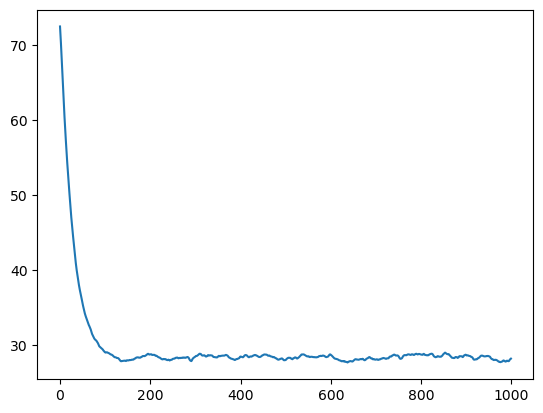

In [26]:
plt.plot(rg)

The next step is to remove the restraint force in order to run the sampling simulation. It also adds a confinement potential with density = 0.1 (volume fraction).

In [27]:
# Remove Flat initialized in Collapse
simulation.removeFlatBottomHarmonic()

# Add a confinement potential with density=0.1 (volume fraction)
simulation.addSphericalConfinementLJ()

14.793027236438204

Initiate the `optimization` object for this tutorial section.

In [28]:
optimization = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", 
                                     TypesTable='input/lambda_0',
                                     mu=3.22, rc = 1.78
                                     )

The next step is to perform a long simulation to feed the optimization parameters. <br>

In order to get a good inversion calcultation, it is important to have around $1\times10^5$ frames from a certain amount of different replicas. For example, $16$ replicas with $5.000$ saved frames from each. <br> 

This can take some time, so in this tutorial we will use just 1 replica of $5.000$ frames saved every $1.000$ steps. <br>

    block = 1000
    n_blocks = 5000

In [29]:
block    = 1000
n_blocks = 5000

In [30]:
for _ in range(n_blocks):
    # perform 1 block of simulation
    simulation.runSimBlock(block, increment=True) 
    # feed the optimization with the last chromosome configuration
    optimization.prob_calculation_types(simulation.getPositions())

bl=1 pos[1]=[29.1 2.2 2.8] dr=4.73 t=5015.0ps kin=1.47 pot=0.00 Rg=28.816 SPS=1589 
bl=2 pos[1]=[30.4 2.2 5.5] dr=4.66 t=5025.0ps kin=1.49 pot=0.00 Rg=29.657 SPS=1497 
bl=3 pos[1]=[28.3 1.0 5.0] dr=4.66 t=5035.0ps kin=1.47 pot=0.00 Rg=30.640 SPS=1570 
bl=4 pos[1]=[25.3 -1.7 4.5] dr=4.67 t=5045.0ps kin=1.45 pot=0.00 Rg=31.640 SPS=1687 
bl=5 pos[1]=[24.2 -0.7 4.1] dr=4.56 t=5055.0ps kin=1.47 pot=0.00 Rg=32.528 SPS=1710 
bl=6 pos[1]=[21.6 2.0 2.8] dr=4.70 t=5065.0ps kin=1.50 pot=0.00 Rg=33.482 SPS=1663 
bl=7 pos[1]=[16.4 6.0 0.9] dr=4.68 t=5075.0ps kin=1.48 pot=0.00 Rg=34.393 SPS=1478 
bl=8 pos[1]=[15.6 7.8 4.2] dr=4.69 t=5085.0ps kin=1.57 pot=0.00 Rg=35.397 SPS=1701 
bl=9 pos[1]=[16.6 6.9 5.8] dr=4.71 t=5095.0ps kin=1.50 pot=0.00 Rg=36.438 SPS=1722 
bl=10 pos[1]=[18.2 6.6 5.8] dr=4.70 t=5105.0ps kin=1.50 pot=0.00 Rg=37.397 SPS=1787 
bl=11 pos[1]=[16.2 5.8 4.9] dr=4.65 t=5115.0ps kin=1.44 pot=0.00 Rg=38.314 SPS=1816 
bl=12 pos[1]=[17.3 5.8 1.9] dr=4.68 t=5125.0ps kin=1.56 pot=0.00 Rg=39.2

In the end of each replica simulation, we need to save some important values required to calculate the inversion. <br>

We are saving these files using the H5 compression because it is faster to write/read. <br>

**Note**: attention to this step. We have these 4 files for each replica for each iteration step. Be organized!

In [ ]:
replica="1"

with h5py.File(simulation.folder + "/Nframes_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Nframes",  data=optimization.Nframes)

with h5py.File(simulation.folder + "/Pold_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold",  data=optimization.Pold)

# Specific for Types minimization
with h5py.File(simulation.folder + "/Pold_type_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold_type",  data=optimization.Pold_type)

with h5py.File(simulation.folder + "/PiPj_type_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("PiPj_type",  data=optimization.PiPj_type)

The first part of the optimization is finished. Look inside the output folder to see these 4 files that will be used in next step.

In [ ]:
%%bash
ls iteration_0/*.h5

iteration_0/Bij_type_1.h5
iteration_0/Nframes_1.h5
iteration_0/Pold_1.h5
iteration_0/polds_type_1.h5


The next part is the inversion. It is quite simple, just feed the optmization object with all replicas and make the inversion to get the new lambda file.

In [ ]:
inversion = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", 
                                  TypesTable='input/lambda_0',
                                  mu=3.22, rc = 1.78
                                  )

In [ ]:
iterations = "iteration_0"
replica    = "1"

with h5py.File(iterations + "/Nframes_" + replica + ".h5", 'r') as hf:
    inversion.Nframes += hf['Nframes'][()]

with h5py.File(iterations + "/Pold_" + replica + ".h5", 'r') as hf:
    inversion.Pold += hf['Pold'][:]

# For Types
with h5py.File(iterations + "/Pold_type_" + + replica + ".h5", 'r') as hf:
    inversion.Pold_type += hf['Pold_type'][:]

with h5py.File(iterations + "/PiPj_type_" + replica + ".h5", 'r') as hf:
    inversion.PiPj_type += hf['PiPj_type'][:]

With the parameters of all replicas, we calculate the inversion and get the new lambdas. It is calculated by using the Newton Method: <br>

$\lambda_1 = \lambda_0 - \delta\times\lambda_{actual}$

$\delta$ is the learning rate or damp, it can be adjusted in order to get values between [-1:0]. The average value of MiChroM's parameters for Human GM12878 is -0.3 

In [ ]:
damp = 3e-7 
lambdas = inversion.get_lambdas_types(exp_map="input/chr10_100k.dense", 
                                      damp=damp
                                      )
print(lambdas)  

         A1        B1
0 -0.423845 -0.475924
1 -0.475924 -0.212862


Save the new lambda (`lambda_1`) and other files to analyze the inversion.

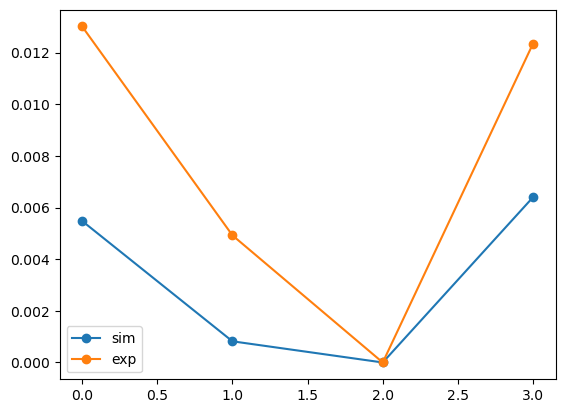

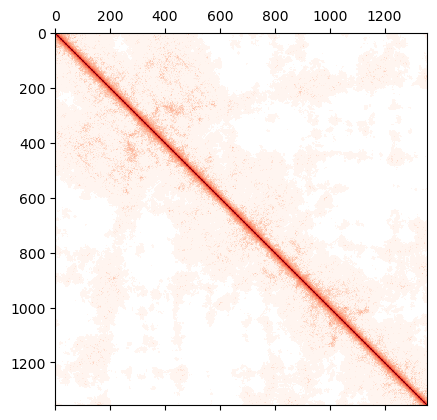

In [ ]:
iteration = "0"

# Probabilities of As/Bs in the simulation and experiment
phi_sim = inversion.calc_phi_sim_types().ravel()
phi_exp = inversion.calc_phi_exp_types().ravel()

np.savetxt('phi_sim_' + iteration, phi_sim)
np.savetxt('phi_exp', phi_exp)

plt.plot(phi_sim, 'o-', label="sim")
plt.plot(phi_exp, 'o-', label="exp")
plt.legend()

# Save and plot the simulated Hi-C
dense_sim = inversion.get_HiC_sim()
np.savetxt('hic_sim_' + iteration + '.dense', dense_sim)
plt.matshow(dense_sim, 
            norm=mpl.colors.LogNorm(vmin=0.0001, 
                                    max=dense_sim.max()
                                    ), 
            cmap="Reds"
            )

# Save the new lambda file
lambdas.to_csv("input/lambda_1", index=False)

Redo these steps using the new lambda file (`lambda_1`) as input for Types potential in the next iteration. 

The tolerance can be calculate using `phi_sim_1` and `phi_exp` by the equation:<br>

$tolerance = \frac{|\phi_{sim}-\phi_{exp}|}{\phi_{exp}}$

This is appended in to file  `tolerance_and_pearson_types`.

In [ ]:
%%bash
cat tolerance_and_pearson_types

Error: 0.621143  Pearson's Correlation: 0.853857


We included a folder named `scripts` that has some `.py` and `.slurm` files that can be used to run this optimization in parallel using slurm clusters. It is located in our github repository https://github.com/junioreif/OpenMiChroM.